<h1 align="center"> Practice</h1>
#  1. reading data (5%)

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)

In [1]:
# start with this code
import pandas as pd
import numpy as np
import math
from utils import InitExponentialSmoothing, BuildForecast, plotTSForecast
from utils import qualityRMSE, qualityMedianAE, qualityMACAPE, qualitySSE, qualityMSE, qualityMAPE 

%matplotlib inline

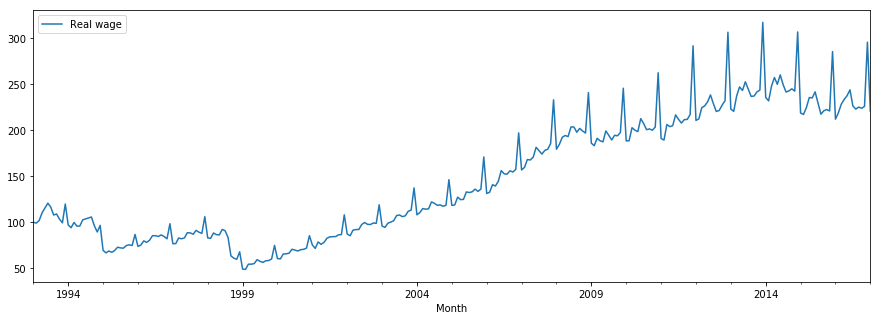

In [2]:
wage = pd.read_csv('monthly-wage.csv',  sep=';', decimal='.', index_col= 0, parse_dates=True, dayfirst=True)

# Put your code below
wage.plot(figsize=(15,5))

# 2. Build the Forecast with  IES (5%)

You need to apply IES model (see seminar 1) for the TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.


* 0) Forecast Wage TS with SES $\alpha=.1$.
* 1) Find the best param $\alpha$ of SES for data period from 09.1998 to 01.2015. Is the optimal value close to 0 or 1? (You 
can choose any loss function above).
* 2) Draw the forecast that correspond to IES with optimial value $\alpha$ (use time steps from 09.1998 to 01.2017.)
     Conclude whether IES can be used for this TS? If can not than explain why.
* 3) Calculate loss of the forecast of TS in [02.2015, 01.2017]. (You can choose any Loss function from seminar 1).

## 1) Search for the optimal $\alpha$ 

### Подыскиваем оптимальное значение $\alpha$ как на семинаре, используя функции из unit.py

In [93]:
ALPHA = np.linspace(0.1,1,10)
IESParamsArray = [{'alpha':alpha, 'AdaptationPeriod':1} for alpha in ALPHA]
FRC_WAGE_IES = BuildForecast(h=1, ts=wage, AlgName='InitExponentialSmoothing', AlgTitle='IES', ParamsArray = IESParamsArray, 
                            step="M")

#### Попробуем найти оптимальные параметры, испльзуя метрику MACAPE

In [94]:
# compare IES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE_IES.keys())

ix = wage.loc['1998-09-01':'2015-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_IES[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(wage.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()

IES {'alpha': 0.40000000000000002, 'AdaptationPeriod': 1}    0.058959
IES {'alpha': 0.5, 'AdaptationPeriod': 1}                    0.059644
IES {'alpha': 0.30000000000000004, 'AdaptationPeriod': 1}    0.060475
IES {'alpha': 0.59999999999999998, 'AdaptationPeriod': 1}    0.060784
IES {'alpha': 0.70000000000000007, 'AdaptationPeriod': 1}    0.061867
IES {'alpha': 0.80000000000000004, 'AdaptationPeriod': 1}    0.062547
IES {'alpha': 0.90000000000000002, 'AdaptationPeriod': 1}    0.062800
IES {'alpha': 1.0, 'AdaptationPeriod': 1}                    0.063358
IES {'alpha': 0.20000000000000001, 'AdaptationPeriod': 1}    0.066311
IES {'alpha': 0.10000000000000001, 'AdaptationPeriod': 1}    0.091833
dtype: float64

## 2) draw the forecast with optimial value $\alpha $

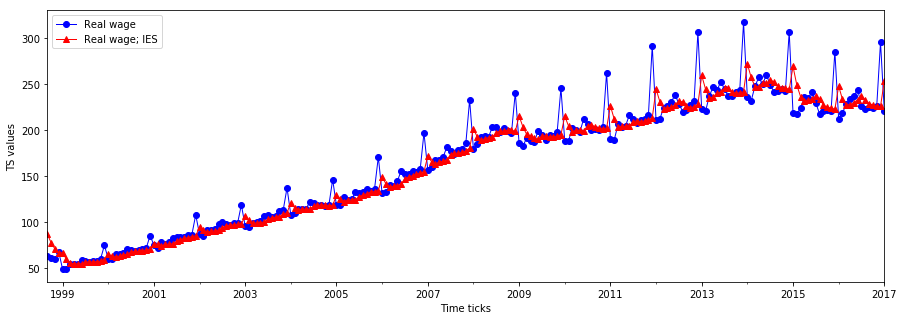

In [95]:
algNameIES = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1998-09-01':'2017-01-01'], FRC_WAGE_IES[algNameIES].loc['1998-09-01':'2017-01-01']
               , ts_num=1, alg_title='IES')

** Question**
    * Does SES follow to the TS components?
    
#### Ответ:
* Видно, что данная модель не очень подходит для прогрнозирования данного ряда, потому что ряд не стационарный, тут есть тренд и сезонность, наша же модель не может "поймать" годичную сезонность ряда и тренд. Также это видно по оптимальному значению $\alpha$ - 0.4, которое указывает на то, что ряд не стационарный и применять данную модель для прогнозирования не очень хорошо.

## 3) Calculate loss of the forecast of TS in [02.2015, 01.2017]

In [96]:
qualityMACAPE(wage.loc['2015-02-01':'2017-01-01'], FRC_WAGE_IES[algNameIES].loc['2015-02-01':'2017-01-01'])[0]

Real wage    0.062764
dtype: float64

# 3. Winters model for Additive Seasonality (25%)
You need to realize ES model for TS with additive seasonality and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize Winters model for Seasonal TS
* 2) Find optimal params $\alpha$ (smoothing of level) and $\gamma$ (smoothing of seasonality) (use data from 09.1998 to 01.2015).(Loss function should be the same as in task 2.)
* 3) Draw the forecast that correspond optimal values $\alpha$ and $\gamma$ (data from 09.1998 to 01.2017). 
* 4) Calculate accuracy of the forecast of TS in [02.2015, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of IES: is it better? 
* 5) Conclude whether Winter's ES can be used for this TS?

#### Модель Винтерса: 
$$\hat{y}=l_t+s_{t-p};$$
$$l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) l_{t-1};$$
    $$ s_t = \gamma (y_t-l_t) + (1-\gamma) s_{t-p}$$

In [86]:
# Start with this code
###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    delts <scalar in [0,1]> - seasonality smoothing parameter

def WintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    delta = Params['delta']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= x[0]
    s= [np.NaN]*p
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = x[cntr]
 
            if math.isnan(s[cntr % p]):
                s[cntr % p] = x[cntr % p]
            
            l_prev = l
            l = alpha*(x[cntr] - s[cntr % p])+(1-alpha)*l_prev
            s[cntr % p] = delta*(x[cntr]-l_prev)+(1-delta)*s[cntr % p]
            
        FORECAST[cntr+h] = l + s[(cntr+h) % p]
    return FORECAST

In [87]:
def BuildForecast(h, ts, AlgName, AlgTitle, ParamsArray, step='M'):
    FRC_TS = dict()
    for p in ParamsArray:
        frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
        frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)

        for cntr in ts.columns:
            frc_ts[cntr] = eval(AlgName)(ts[cntr], h, p)

    #         frc_ts.columns = frc_ts.columns+('%s %s' % (AlgTitle, p))
        FRC_TS['%s %s' % (AlgTitle, p)] = frc_ts
    return FRC_TS

#### Подберём подходящие параметры

In [88]:
%%time
# Put your code here
DELTA = np.linspace(0.1,1,10)
ALPHA = np.linspace(0.1,1,10)

# по графику видно, что сезонность равна 1 году или 12 месяцам
WESParamsArray = [{'alpha':alpha, 'delta':delta, 'seasonality_period': 12} 
                  for delta in DELTA 
                     for alpha in ALPHA]
FRC_WAGE_WES=BuildForecast(h=1, ts=wage, AlgName = 'WintersExponentialSmoothing', AlgTitle='WES', ParamsArray = WESParamsArray)

Wall time: 1.76 s


In [89]:
# compare WES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE_WES.keys())

ix = wage.loc['1998-09-01':'2015-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_WES[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(wage.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()[:10]

WES {'alpha': 0.40000000000000002, 'delta': 0.5, 'seasonality_period': 12}                    0.030234
WES {'alpha': 0.5, 'delta': 0.40000000000000002, 'seasonality_period': 12}                    0.030293
WES {'alpha': 0.40000000000000002, 'delta': 0.40000000000000002, 'seasonality_period': 12}    0.030532
WES {'alpha': 0.5, 'delta': 0.5, 'seasonality_period': 12}                                    0.030561
WES {'alpha': 0.40000000000000002, 'delta': 0.59999999999999998, 'seasonality_period': 12}    0.031189
WES {'alpha': 0.59999999999999998, 'delta': 0.40000000000000002, 'seasonality_period': 12}    0.031381
WES {'alpha': 0.5, 'delta': 0.59999999999999998, 'seasonality_period': 12}                    0.031490
WES {'alpha': 0.59999999999999998, 'delta': 0.5, 'seasonality_period': 12}                    0.032009
WES {'alpha': 0.5, 'delta': 0.30000000000000004, 'seasonality_period': 12}                    0.032092
WES {'alpha': 0.40000000000000002, 'delta': 0.30000000000000004, 'seasona

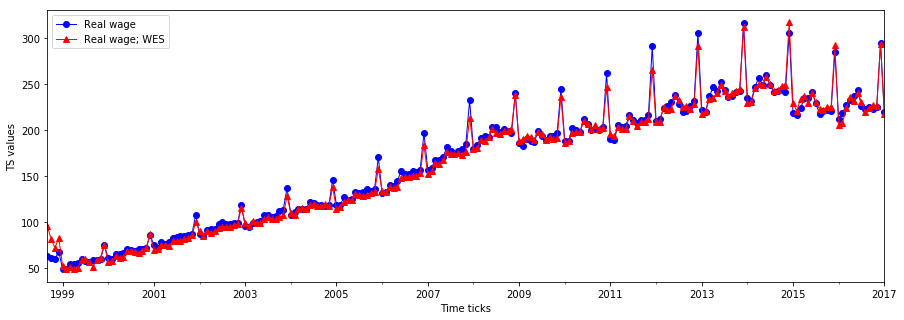

In [90]:
algNameWES = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1998-09-01':'2017-01-01'], FRC_WAGE_WES[algNameWES].loc['1998-09-01':'2017-01-01']
               , ts_num=1, alg_title='WES')

#### Изобразим на одном графике результаты работы IES и WES, видно, что WES лучше ловит сезонность

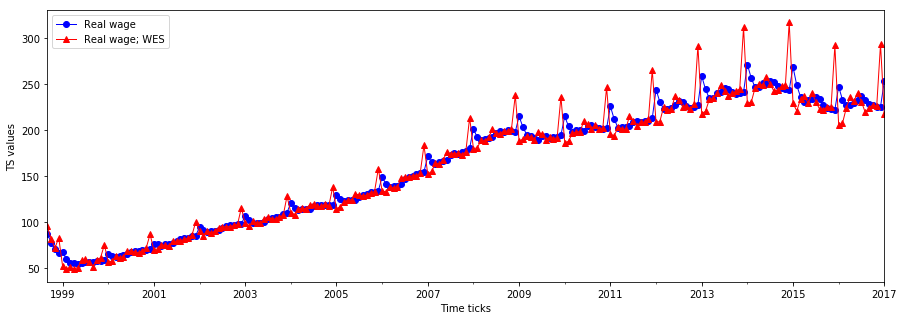

In [91]:
algNameWES = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(FRC_WAGE_IES[algNameIES].loc['1998-09-01':'2017-01-01'], FRC_WAGE_WES[algNameWES].loc['1998-09-01':'2017-01-01']
               , ts_num=1, alg_title='WES')

### Значение ошибки у модели WES также лучше, чем у IES

In [92]:
qualityMACAPE(wage.loc['2015-02-01':'2017-01-01'], FRC_WAGE_WES[algNameWES].loc['2015-02-01':'2017-01-01'])[0]

Real wage    0.01755
dtype: float64

### Таким образом, можно сделать вывод, что WES использовать предпочтительней, когда есть сезонность 

# 4. Theil-Wage model for TS with linear trend and seasonality (25%)
You need to realize Theil-Wage model and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize Theil-Wage model for
* 2) Find optimal params $\alpha$ (smoothing of level), $\beta$ (smoothing trend) and $\gamma$ (smoothing of seasonality) (use data from 09.1998 to 01.2015).(Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values $\alpha$, $\beta$ and $\gamma$ from 09.1998 to 01.2017. 
* 4) Calculate accuracy of the forecast of TS in [02.2015, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model: is it better than the last one? 
* \*5) Suggest how can the Theil-Wage model be improved to make accuracy of forecast better?

#### Модель Тейла-Вейджа:$$\hat{y} = (l_t + b_t d) + s_{t-p};$$, 
$$l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) (l_{t-1} + b_{t-1} );$$,
    $$ b_t = \beta (l_{t} - l_{t-1} ) + (1-\beta) b_{t-1};$$,
    $$ s_t = \gamma (y_t-l_t) + (1-\gamma) s_{t-p}.$$

In [230]:
# Put your code here
###################### Theil-Wage model #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    gamma <scalar in [0,1]> - seasonality smoothing parameter
#    beta <scalar in [0,1]> - trend smoothing parameter

def TheilWageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= x[0]
    s= [np.NaN]*p
    b= x[0]
    l_prev= 0
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = x[cntr]
 
            if math.isnan(s[cntr % p]):
                s[cntr % p] = x[cntr %p]
            
            if math.isnan(b):
                b = x[cntr]
            
            l_prev = l
            b_prev = b
            s_prev = s[cntr % p]
            l = alpha*(x[cntr] - s[cntr % p])+(1-alpha)*(l_prev+b_prev)
            b = beta*(l-l_prev)+(1-beta)*b_prev
            s[cntr % p] = gamma*(x[cntr]-l)+(1-gamma)*s_prev
            
        FORECAST[cntr+h] = l + b*h + s[(cntr+h) % p]
    return FORECAST


In [236]:
%%time
# Put your code here
ALPHA = np.linspace(0.1,1,10)[:-1]
BETA = np.linspace(0.1,1,10)[:-1]
GAMMA = np.linspace(0.1,1,10)[:-1]
THWESParamsArray = [{'alpha':alpha, 'gamma':gamma, 'beta':beta, 'seasonality_period': 12} 
                  for gamma in GAMMA 
                     for alpha in ALPHA
                       for beta in BETA]
FRC_WAGE_THWES=BuildForecast(h=1, ts=wage, AlgName = 'TheilWageExponentialSmoothing', AlgTitle='THWES', 
                             ParamsArray = THWESParamsArray)

Wall time: 13.5 s


In [240]:
%%time
# compare IES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE_THWES.keys())

ix = wage.loc['1998-09-01':'2015-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_THWES[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage.loc[ix], frc_wage.loc[ix])

print(QualityStr[QualityStr.columns].mean().sort_values()[:5])

THWES {'alpha': 0.30000000000000004, 'gamma': 0.90000000000000002, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.034501
THWES {'alpha': 0.30000000000000004, 'gamma': 0.80000000000000004, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.035586
THWES {'alpha': 0.30000000000000004, 'gamma': 0.59999999999999998, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.036479
THWES {'alpha': 0.30000000000000004, 'gamma': 0.5, 'beta': 0.10000000000000001, 'seasonality_period': 12}                    0.036492
THWES {'alpha': 0.30000000000000004, 'gamma': 0.70000000000000007, 'beta': 0.10000000000000001, 'seasonality_period': 12}    0.036558
dtype: float64
Wall time: 1.78 s


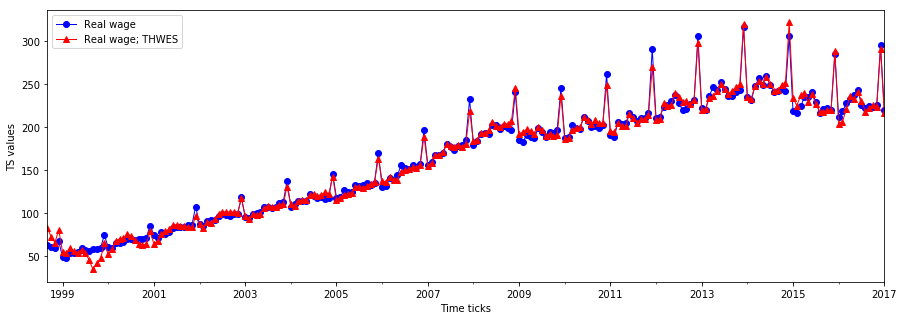

In [241]:
algNameTHWES = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1998-09-01':'2017-01-01'], FRC_WAGE_THWES[algNameTHWES].loc['1998-09-01':'2017-01-01']
               , ts_num=0, alg_title='THWES')

#### Изобразим на одном графике результаты работы THWES и WES, они работают почти одинаково, при этом модель Тейла-Вейджа очень сильно реагирует на начальную инициализацию

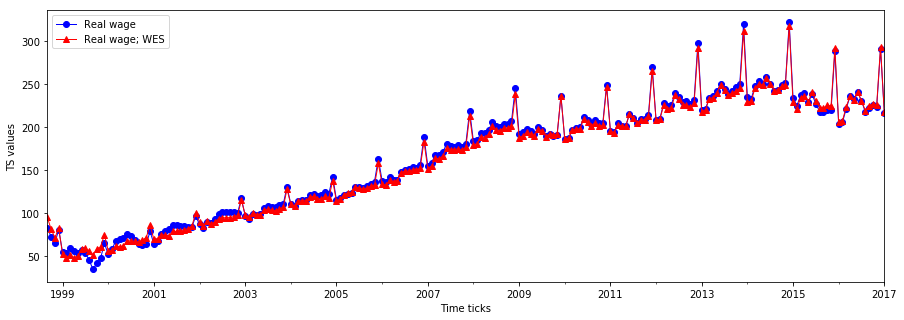

In [242]:
algNameTHWES = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(FRC_WAGE_THWES[algNameTHWES].loc['1998-09-01':'2017-01-01'], FRC_WAGE_WES[algNameWES].loc['1998-09-01':'2017-01-01']
               , ts_num=1, alg_title='WES')

In [243]:
qualityMACAPE(wage.loc['2015-02-01':'2017-01-01'], FRC_WAGE_THWES[algNameTHWES].loc['2015-02-01':'2017-01-01'])[0]

Real wage    0.018828
dtype: float64

# 5. Non-additive model of ES (25%)
You need to realize some ES-model that include non-addive component (or multiplicative trend or multiplicative component) and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize one of following ES models: ESM(A,M) (t.e. Holt-Winters model), ESM(Ad,M), ESM(M,A), ESM(M,M) model.
* 2) Find optimal params of the model (use data from 09.1998 to 01.2015). Note: if you choose damped trend model that $\phi$ you can just set it by expert opinion (say $0.98$). (Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values of it's params (data from 09.1998 to 01.2017). 
* 4) Calculate accuracy of the forecast of TS in [02.2015, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model and Theil-Wage model: is it better than the last one? 
* 5) Is it true that multiplicative model are more unstable than additive? Unstable means thet forecast is can diveret

#### Модель Винтерса: :$$\hat{y} = l_t s_{t-p};$$, 
$$l_t = \alpha (\frac{y_t}{s_{t-p}}) + (1-\alpha) l_{t-1};$$,
    $$ s_t = \beta (\frac{y_t}{l_t}) + (1-\beta) s_{t-p}.$$


In [198]:
# Put your code here
###################### Theil-Wage model #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    beta <scalar in [0,1]> - seasonality smoothing parameter

def WintersModel(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= [np.NaN]*p
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = x[cntr]
 
            if math.isnan(s[cntr % p]):
                s[cntr % p] = x[cntr%p]
            
            
            l_prev = l
            l = alpha*(x[cntr]/s[cntr % p])+(1-alpha)*l_prev
            s[cntr % p] = beta*(x[cntr]/l_prev)+(1-beta)*s[cntr % p]
            
        FORECAST[cntr+h] = l * s[(cntr+h) % p]
    return FORECAST


In [199]:
%%time
# Put your code here
# BETA = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
# ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01, 0.3]
ALPHA = np.linspace(0.1,1,10)[:-1]
BETA = np.linspace(0.1,1,10)[:-1]
WMParamsArray = [{'alpha':alpha,'beta':beta, 'seasonality_period': 12} 
                 for alpha in ALPHA
                   for beta in BETA]
FRC_WAGE_WM=BuildForecast(h=1, ts=wage, AlgName = 'WintersModel', AlgTitle='WM', 
                             ParamsArray = WMParamsArray)

Wall time: 1.44 s


In [200]:
# compare IES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE_WM.keys())

ix = wage.loc['1998-09-01':'2015-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_WM[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(wage.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()[:10]

WM {'alpha': 0.5, 'beta': 0.30000000000000004, 'seasonality_period': 12}                    0.026966
WM {'alpha': 0.5, 'beta': 0.20000000000000001, 'seasonality_period': 12}                    0.027540
WM {'alpha': 0.40000000000000002, 'beta': 0.30000000000000004, 'seasonality_period': 12}    0.028623
WM {'alpha': 0.40000000000000002, 'beta': 0.40000000000000002, 'seasonality_period': 12}    0.029027
WM {'alpha': 0.5, 'beta': 0.40000000000000002, 'seasonality_period': 12}                    0.029484
WM {'alpha': 0.40000000000000002, 'beta': 0.20000000000000001, 'seasonality_period': 12}    0.029566
WM {'alpha': 0.59999999999999998, 'beta': 0.30000000000000004, 'seasonality_period': 12}    0.029998
WM {'alpha': 0.40000000000000002, 'beta': 0.5, 'seasonality_period': 12}                    0.030228
WM {'alpha': 0.59999999999999998, 'beta': 0.20000000000000001, 'seasonality_period': 12}    0.031709
WM {'alpha': 0.40000000000000002, 'beta': 0.59999999999999998, 'seasonality_period': 12}   

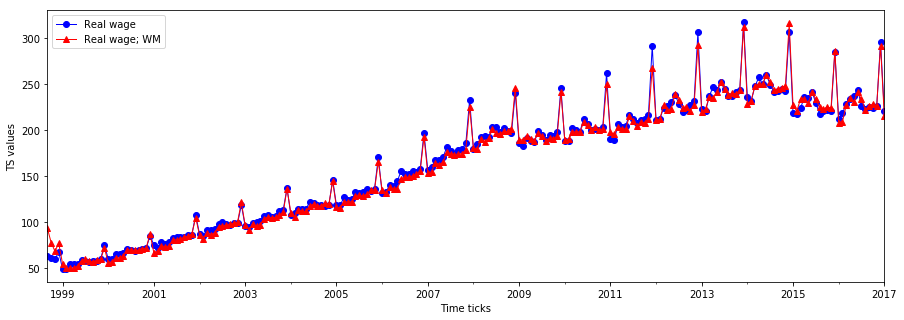

In [201]:
algNameWM = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1998-09-01':'2017-01-01'], FRC_WAGE_WM[algNameWM].loc['1998-09-01':'2017-01-01']
               , ts_num=1, alg_title='WM')

### Видно, что не аддитиваная модель Винтерса довольно неплохо предсказывает наш ряд 

In [225]:
qualityMACAPE(wage.loc['2015-02-01':'2017-01-01'], FRC_WAGE_WM[algNameWM].loc['2015-02-01':'2017-01-01'])[0]

Real wage    0.01657
dtype: float64